<a href="https://colab.research.google.com/github/tarabelo/PIAC-apuntes/blob/main/Pr%C3%A1ctica%204%3A%20algoritmo%20de%20Simon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAQUEL ALFONSO RODRÍGUEZ**

# Práctica 4: algoritmo de Simon

Implementa en Qiskit el algoritmo de Simon para un $n$ y un $c$ arbitrario y el oráculo simple que hemos visto.

Empieza implementando el oráculo como una puerta.

Para probarlo, supón $n=3$ y $c$ un valor aleatorio en el intervalo $[0,7]$. Obtén el valor de $c$ a partir de la salida del algoritmo.

### Solución ###

Siguiendo los pasos de las anteriores prácticas, primero definiremos un $c$ aleatorio entre [0, 7], después programaremos el oráculo (siguiendo las pautas del ejercicio 7) y finalmente, crearemos el circuito del algoritmo.

In [ ]:
# Instalamos qiskit en el notebook
!pip install qiskit qiskit-aer pylatexenc

In [1]:
import numpy as np
from math import sqrt

# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
# import basic plot tools
from qiskit.visualization import plot_histogram

# Funciones auxiliares

# Función para simular y mostrar el vector de estado
def obten_estado(qcirc, etiqueta="|\psi\!\!> = ", bloch=False):
    # Usamos el simulador de vector de estado
    # https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html
    sim = AerSimulator(method='statevector')
    qc_obj = transpile(qcirc, sim)
    result = sim.run(qc_obj).result()
    estado = result.get_statevector()
    display(estado.draw('latex', prefix=etiqueta))
    if bloch:
      display(estado.draw('bloch'))

# Funcion para obtener y mostrar la matriz unitaria
def obten_unitaria(qcirc, etiqueta):
    # Usamos el simulador de matriz unitaria
    sim_u = AerSimulator(method='unitary')
    qc_obj = transpile(qcirc, sim_u)
    result = sim_u.run(qcirc).result()
    unitary = result.get_unitary(qcirc)
    display(unitary.draw('latex', prefix=etiqueta))

In [2]:
# Periodicidad c

def get_c(n):
    c = list()
    for q in range(n):
        if np.random.randint(2) == 1:
            c.append(1)
        else:
            c.append(0)
    return(c)

In [3]:
def simon_oraculo2(n,c):
    x = QuantumRegister(n, name="|x\\rangle")
    ancilla = QuantumRegister(n, name="|ancilla\\rangle")
    meas = ClassicalRegister(n, name="Medida")
    qc = QuantumCircuit(x, ancilla, meas)

    # Hacemos la copia de la x a las ancillas
    qc.cx(x,ancilla)

    qc.barrier()
    
    cinv = c[::-1]

    # Localizamos el bit 1 menos significativo de c y aplicamos una CNOT desde ese qubit a todas
    # las otras posiciones que tengan un 1 en c
    
    for i in range(n):
        if cinv[i]==1:
            for j in range(i, n):
                if cinv[j]==1:
                    qc.cx(x[i], ancilla[j])
            break

    qc.barrier()

    qc.measure(ancilla, meas)
    return(qc)

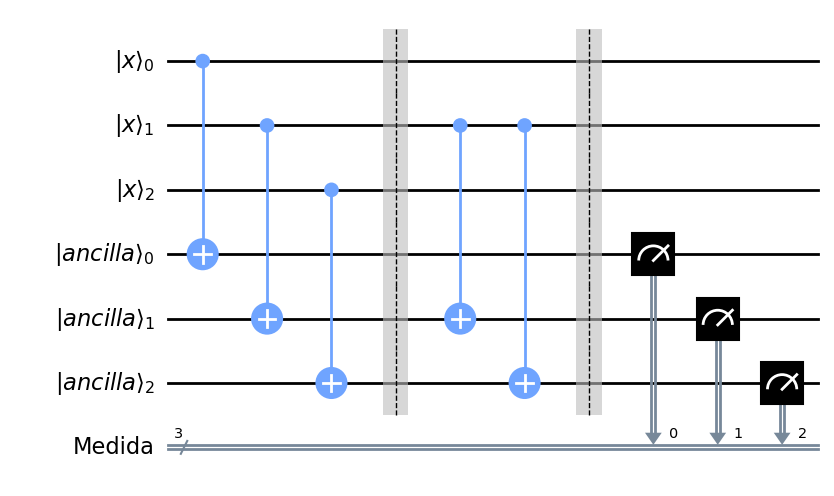

In [5]:
qc = simon_oraculo2(3, [1, 1, 0])
qc.draw('mpl', style='clifford')

In [6]:
# Creamos el circuito

def simon_circuit(init,n,c):

    x = QuantumRegister(n, name="|x\\rangle")
    ancilla = QuantumRegister(n, name="|ancilla\\rangle")
    meas = ClassicalRegister(n, name="Medida")
    qc = QuantumCircuit(x, ancilla, meas)
    qc.initialize(init)

    for i in range(n):
        qc.h(x[i])
    
    qc = qc.compose(simon_oraculo2(n,c))

    qc.barrier()

    for i in range(n):
        qc.h(x[i])
        qc.measure(x[i], meas[i])

    # Dibujamos el circuito
    
    return(qc)

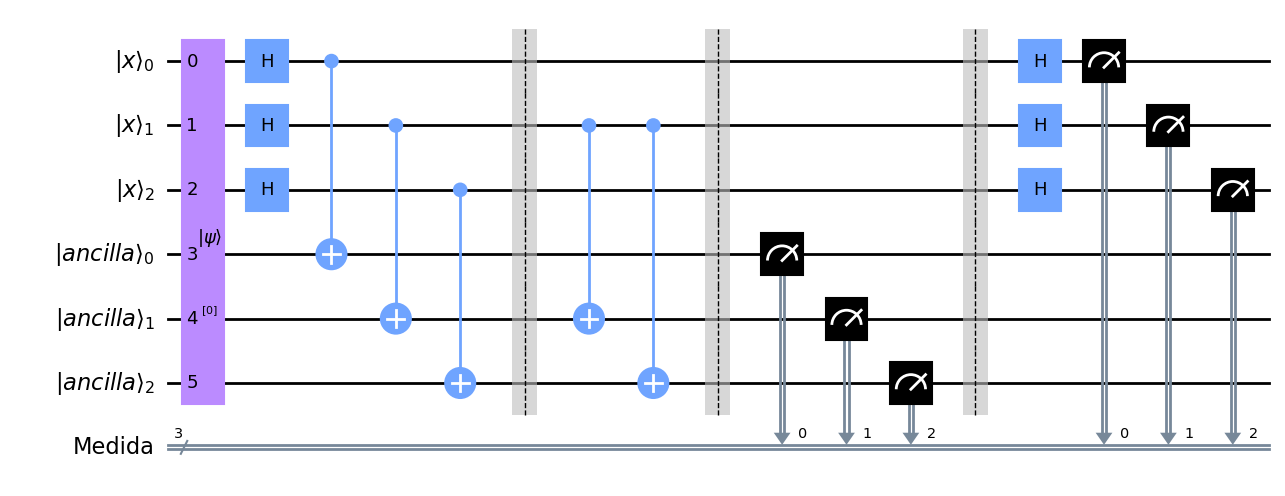

In [7]:
qc = simon_circuit(0,3,[1,1,0])
qc.draw('mpl', style='clifford')

### Resultados ###

Hacemos la comprobación para el ejemplo de $n=3$ y $c=110$.

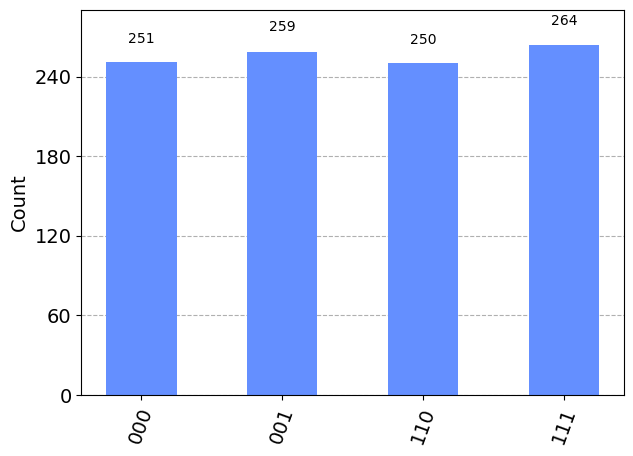

In [8]:
n = 3
init = 0
c = [1,1,0]

simon_circuito = simon_circuit(init,n,c)

sim = AerSimulator(method='automatic')
qc_obj = transpile(simon_circuito, sim)
result = sim.run(qc_obj, shots = 1024).result()

salida = result.get_counts()

plot_histogram(salida)

Como vemos, en el resultado tenemos $000$, $001$, $110$ y $111$. Si resolvemos el sistema de ecuaciones

$$ 000 \cdot c_2 c_1 c_0 = 0 \qquad (1)$$
$$ 001 \cdot c_2 c_1 c_0 = 0 \qquad (2)$$
$$ 110 \cdot c_2 c_1 c_0 = 0 \qquad (3)$$
$$ 111 \cdot c_2 c_1 c_0 = 0 \qquad (4)$$

obtenemos de (2) $c_0 = 0$ y de (3) y (4) sale 

$$ c_2 = 0, c_1 = 0$$
o
$$ c_2 = 1, c_1 = 1.$$

Como no puede ser $c=000$, la única opción es que $c=110$, que es lo que esperábamos obtener.

### Prueba ###

Hagamos ahora un ejemplo con un $c$ aleatorio.

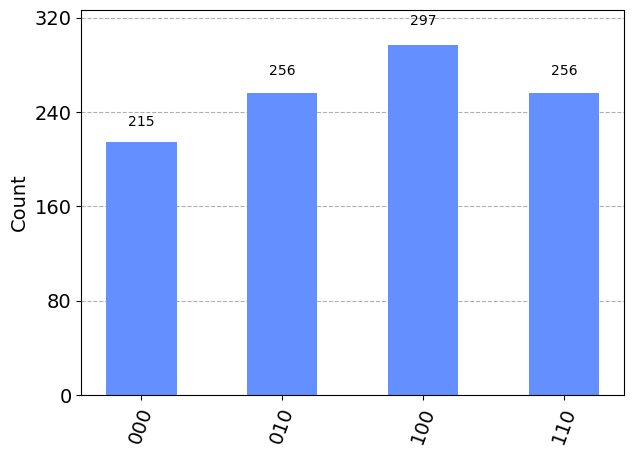

In [9]:
n = 3
init = 0
c = get_c(n)

simon_circuito = simon_circuit(init,n,c)

sim = AerSimulator(method='automatic')
qc_obj = transpile(simon_circuito, sim)
result = sim.run(qc_obj, shots = 1024).result()

salida = result.get_counts()

plot_histogram(salida)

En este caso, obtuvimos

$$ 000 \cdot c_2 c_1 c_0 = 0 \qquad (1)$$
$$ 010 \cdot c_2 c_1 c_0 = 0 \qquad (2)$$
$$ 100 \cdot c_2 c_1 c_0 = 0 \qquad (3)$$
$$ 110 \cdot c_2 c_1 c_0 = 0 \qquad (4)$$

obtenemos de (2) $c_1 = 0$, de (3) $c_2 = 0$ y de (4)

$$ c_2 \cdot 1 \oplus c_1 \cdot 1 \oplus c_0 \cdot 0 = 0. $$

Como $c_2 = 0$ y $c_1 = 0$, entonces $c_0$ puede ser $c_0 =0$ o $c_0=1$. De nuevo, como no puede ser $c=000$, entonces necesariamente $c=001$.

In [10]:
print(c)

[0, 0, 1]


--------------------
-------------------
------------------